## Neural Language Translation with Attention

#### Reference
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#loading-data-files

In [36]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

### Define Helper Functions

In [3]:
SOS_token = 0
EOS_token = 1

class Language:
    def __init__(self, name):
        self.name = name
        self.word2idx = {"SOS": 0, "EOS": 1}
        self.word2count = {}
        self.idx2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # include SOS and EOS tokens
        
    def add_sentence(self, sentence):
        for word in sentence.split(" "):
            self.add_word(word)
        
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.idx2word[self.n_words] = word
            self.word2count[word] = 1
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
def unicodeToAscii(s):
    '''
    Turn a Unicode string to plain ASCII
    '''
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    '''
    Lowercase, trim, and remove non-letter characters
    '''
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
def read_languages(lang1, lang2, reverse=False):
    print("Reading lines...")
    
    with open("data/{0}-{1}.txt".format(lang1, lang2), encoding='utf-8') as f:
        pairs = []
        for line in f.readlines():
            line = line.strip()
            
            # split the line into lang1 - lang2 pair and normalize them
            pair = [normalizeString(s) for s in line.split("\t")]
            pairs.append(pair)
            
    # Reverse pairs and make Language instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Language(lang2)
        output_lang = Language(lang1)
    else:
        input_lang = Language(lang1)
        output_lang = Language(lang2)

    return input_lang, output_lang, pairs

Trim the dataset to include only shorter sentences that start with the given prefixes

In [6]:
# the sentence should be shorter than the max length
MAX_LENGTH = 10

# the english sentence should start with the given prefixes
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

### Data Preparation

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_languages(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je ne suis pas ce genre de gars .', 'i m not that type of guy .']


### Building the Model

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        '''
        Parameters
        ----------
        vocab_size - int
            Vocabulary size of the input language
        hidden_size - int
            Size of the hidden state of rnn
        embedding_size - int
            Size of the embedding dim
        '''
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        
        self.embedding = nn.Embedding(vocab_size, self.embedding_size)
        self.lstm = nn.LSTM(self.embedding_size, hidden_size, batch_first=True)

    def forward(self, sentence, hidden):
        '''
        Parameters
        -----------
        sentence - torch.Tensor([], dtype=int64)
            idxs of words in a sentence
        hidden - (torch.Tensor([1, 1, hidden_size], dtype=float32), 
                  torch.Tensor([1, 1, hidden_size], dtype=float32)), 
            previous hidden state
        '''
        sentence_length = sentence.size(0)
        word_embeds = self.embedding(sentence)
        out = word_embeds.view(1, sentence_length, self.embedding_size)
        lstm_out, hidden = self.lstm(out, hidden)
        return lstm_out, hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size, dtype=torch.float32),
                torch.zeros(1, 1, self.hidden_size, dtype=torch.float32))

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        # network to compute attention scores
        self.attn = nn.Linear(self.embedding_size + self.hidden_size,
                              self.max_length)
        self.attn_combine = nn.Linear(self.embedding_size + self.hidden_size,
                                      self.embedding_size)
        
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTMCell(self.embedding_size, self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, self.vocab_size)

    def forward(self, word, hidden, encoder_outputs):
        embed = self.embedding(word)
        embed = self.dropout(embed)
        
        # compute attention scores
        combine_vector = torch.cat((embed, hidden[0]), dim=1)
        attn_weights = F.softmax(self.attn(combine_vector), dim=1)
                
        # apply attention scores to encoders and get final attention vector
        attn_applied = attn_weights @ encoder_outputs
        
        out = torch.cat((embed, attn_applied), 1)
        out = self.attn_combine(out)

        out = F.relu(out)
        hidden = self.lstm(out, hidden)
                
        out = F.log_softmax(self.fc(hidden[0]), dim=1)
        return out, hidden, attn_weights

    def init_hidden(self):
        return (torch.zeros(1, self.hidden_size, dtype=torch.float32),
                torch.zeros(1, self.hidden_size, dtype=torch.float32))

#### Intialize Models

In [10]:
EMBEDDING_SIZE = 64
HIDDEN_SIZE = 128
INP_VOCAB_SIZE = input_lang.n_words
OUT_VOCAB_SIZE = output_lang.n_words

In [11]:
encoder = EncoderRNN(INP_VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE)
decoder = AttnDecoderRNN(OUT_VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE)

### Training the model

#### Define helper functions

In [12]:
def idx_from_sentence(lang, sentence):
    return [lang.word2idx[word] for word in sentence.split(' ')]

def tensor_from_sentence(lang, sentence):
    sentence_idxs = idx_from_sentence(lang, sentence)
    sentence_idxs.append(EOS_token)
    return torch.tensor(sentence_idxs, dtype=torch.int64).view(-1, 1)

def tensors_from_pair(pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#### test inference

In [13]:
sample_pair = pairs[random.randint(1, 100)]
inpt_tensor, tgt_tensor = tensors_from_pair(sample_pair)

In [14]:
# compute encoder outputs
encoder_outputs = torch.zeros(decoder.max_length, encoder.hidden_size)

encoder_hidden = encoder.init_hidden()
lstm_out, encoder_hidden = encoder(inpt_tensor, encoder_hidden)

lstm_out = lstm_out.flatten(0, 1)
sen_length = lstm_out.size(0)
encoder_outputs[:sen_length, :] = lstm_out

In [15]:
# computer decoder outputs

decoder_input = torch.tensor([SOS_token], dtype=torch.int64)
decoder_hidden = (encoder_hidden[0][0], encoder_hidden[1][0])

In [16]:
decoder_output, decoder_hidden, decoder_attention = decoder(
    decoder_input, decoder_hidden, encoder_outputs)

#### Define training functions

In [17]:
teacher_forcing_ratio = 0.5


def train_pair(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    
    # clear gradient
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # get input and target sequence length
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    # compute encoder outputs
    encoder_outputs = torch.zeros(decoder.max_length, encoder.hidden_size)

    encoder_hidden = encoder.init_hidden()
    lstm_out, encoder_hidden = encoder(input_tensor, encoder_hidden)

    lstm_out = lstm_out.flatten(0, 1)
    encoder_outputs[:input_length, :] = lstm_out

    # initialize loss
    loss = 0
    
    # compute decoder outputs

    decoder_input = torch.tensor([SOS_token], dtype=torch.int64)
    
    decoder_hidden = (encoder_hidden[0][0], encoder_hidden[1][0])

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            # get word with top probability
            top_val, top_idx = decoder_output.topk(1)
            decoder_input = top_idx.detach()[0]  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [18]:
learning_rate=0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [26]:
def train_one_epoch(encoder, decoder, pairs):
    
    loss_per_epoch = 0
    
    # get training pairs
    random.shuffle(pairs)
    training_pairs = [tensors_from_pair(pair) for pair in pairs]
    
    for i in tqdm(range(1, len(pairs) + 1)):
        training_pair = training_pairs[i-1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss_per_pair = train_pair(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        loss_per_epoch += loss_per_pair

    return loss_per_epoch / len(pairs)

In [28]:
n_epochs = 20
losses = []
for i in range(n_epochs):
    loss = train_one_epoch(encoder, decoder, pairs)
    losses.append(loss)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10599/10599 [02:13<00:00, 79.49it/s]


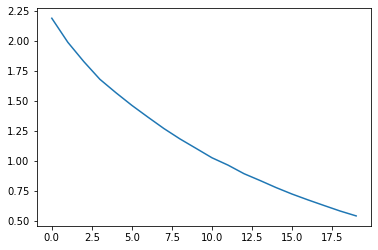

In [39]:
plt.plot(losses)

### Evaluation

In [29]:
def evaluate(encoder, decoder, sentence):
    with torch.no_grad():
        
       # get input sentence
        input_tensor = tensor_from_sentence(input_lang, sentence)
        input_length = input_tensor.size(0)

        # compute encoder outputs
        encoder_outputs = torch.zeros(decoder.max_length, encoder.hidden_size)

        encoder_hidden = encoder.init_hidden()
        lstm_out, encoder_hidden = encoder(input_tensor, encoder_hidden)

        lstm_out = lstm_out.flatten(0, 1)
        encoder_outputs[:input_length, :] = lstm_out

        # compute decoder outputs
        decoder_input = torch.tensor([SOS_token], dtype=torch.int64)

        decoder_hidden = (encoder_hidden[0][0], encoder_hidden[1][0])

        decoded_words = []
        decoder_attentions = torch.zeros(decoder.max_length,
                                         decoder.max_length)

        for di in range(decoder.max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            decoder_attentions[di] = decoder_attention.data
            top_val, top_idx = decoder_output.data.topk(1)
            
            if top_idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.idx2word[top_idx.item()])

            decoder_input = top_idx.detach()[0]

        return decoded_words, decoder_attentions[:di + 1]

In [30]:
def evaluate_at_random(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [35]:
evaluate_at_random(encoder, decoder, n=10)

> il est aime de tous .
= he is liked by everybody .
< he is crazy by everybody . <EOS>

> je suis prete si tu l es .
= i m ready if you are .
< i m ready if you are . <EOS>

> elle se brosse les cheveux .
= she is brushing her hair .
< she is brushing her hair . <EOS>

> tu es trop faible .
= you re too weak .
< you re too weak . <EOS>

> je suis plus que content .
= i m more than happy .
< i m more than happy . <EOS>

> il est ici pour fomenter des troubles .
= he s here trying to stir up trouble .
< he s here to come on trouble . <EOS>

> tu n es pas ma mere .
= you re not my mother .
< you re not my mother . <EOS>

> je suis tres attiree par vous .
= i m very drawn to you .
< i m very drawn to you . <EOS>

> nous sommes fiables .
= we re reliable .
< we re reliable . <EOS>

> ils bronzent autour de la piscine .
= they re sunbathing around the pool .
< they re sunbathing around the pool . <EOS>



### Visualize Attention

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


/var/folders/x5/d37391zn23lbz242jwvsrdnnmnmcwd/T/ipykernel_8774/4221700367.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/x5/d37391zn23lbz242jwvsrdnnmnmcwd/T/ipykernel_8774/4221700367.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


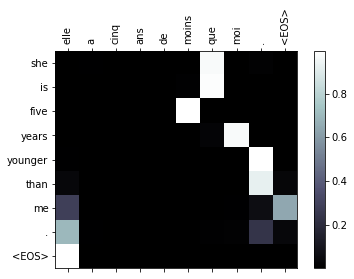

input = elle est trop petit .
output = she s too loud . <EOS>


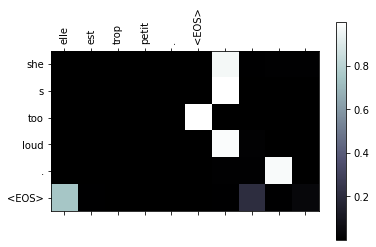

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


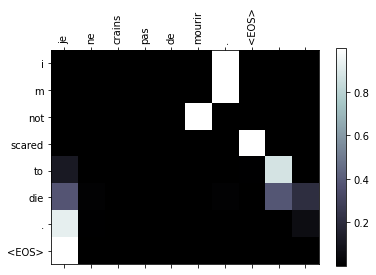

input = c est un jeune directeur plein de talent .
output = he s a talented young . . <EOS>


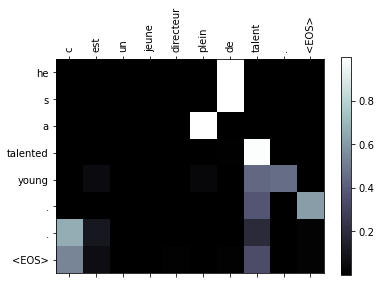

In [38]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)


evaluate_and_show_attention("elle a cinq ans de moins que moi .")

evaluate_and_show_attention("elle est trop petit .")

evaluate_and_show_attention("je ne crains pas de mourir .")

evaluate_and_show_attention("c est un jeune directeur plein de talent .")